# Set up 

In [1]:
topology='B'
omission='reg1-stronger'

In [2]:
SEED = 1
import random

import tellurium as te
import pandas as pd
import numpy as np
np.random.seed(SEED)

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp
import math

import cloudpickle
import gzip

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
os.chdir('../../..')
from src import antemll, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyB/all_data/')

## Perturbing enzymes

In [4]:
ant ='../../../models/Antimony/TopologyB-reg1-stronger.ant'
r = te.loada(ant)
r.conservedMoietyAnalysis = True
r.steadyState()

8.717067455815894e-16

In [5]:
pt_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 1.5, 3, 5, 7, 10]
pt_labels = ['0.1x', '0.2x', '0.3x', '0.4x','0.5x', '1.5x', '3x', '5x', '7x', '10x']

In [6]:
data_file01 = '../../../data/generated_data/TopologyB-reg1-stronger/TopologyB-reg1-stronger_0.1.csv'
data_file02 = '../../../data/generated_data/TopologyB-reg1-stronger/TopologyB-reg1-stronger_0.2.csv'
data_file03 = '../../../data/generated_data/TopologyB-reg1-stronger/TopologyB-reg1-stronger_0.3.csv'
data_file04 = '../../../data/generated_data/TopologyB-reg1-stronger/TopologyB-reg1-stronger_0.4.csv'
data_file05 = '../../../data/generated_data/TopologyB-reg1-stronger/TopologyB-reg1-stronger_0.5.csv'

data_file15 = '../../../data/generated_data/TopologyB-reg1-stronger/TopologyB-reg1-stronger_1.5.csv'
data_file3 = '../../../data/generated_data/TopologyB-reg1-stronger/TopologyB-reg1-stronger_3.csv'
data_file5 = '../../../data/generated_data/TopologyB-reg1-stronger/TopologyB-reg1-stronger_5.csv'
data_file7 = '../../../data/generated_data/TopologyB-reg1-stronger/TopologyB-reg1-stronger_7.csv'
data_file100 = '../../../data/generated_data/TopologyB-reg1-stronger/TopologyB-reg1-stronger_10.csv'


In [7]:
BMCA_obj01 = antemll.antemll(ant, data_file01, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj02 = antemll.antemll(ant, data_file02, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj03 = antemll.antemll(ant, data_file03, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj04 = antemll.antemll(ant, data_file04, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj05 = antemll.antemll(ant, data_file05, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')

BMCA_obj15 = antemll.antemll(ant, data_file15, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj3 = antemll.antemll(ant, data_file3, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj5 = antemll.antemll(ant, data_file5, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj7 = antemll.antemll(ant, data_file7, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj100 = antemll.antemll(ant, data_file100, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


# Running HMC

In [ ]:
def run_HMC(BMCA_obj):
    np.random.seed(SEED)
    random.seed(SEED)

    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    
    with pymc_model:
        trace = pm.sample(
            draws=1000,
            tune=1000,
            step=pm.NUTS(),
            random_seed=123,
            cores=4,         # this controls parallel chains
            chains=4,        # optional, default = cores
            init="auto",     # or "adapt_diag"
            n_init=1000
        )

        ppc_vi = pm.sample_posterior_predictive(trace)

    return trace, ppc_vi

In [9]:
trace01, ppc01 = run_HMC(BMCA_obj01)
trace02, ppc02 = run_HMC(BMCA_obj02)
trace03, ppc03 = run_HMC(BMCA_obj03)
trace04, ppc04 = run_HMC(BMCA_obj04)
trace05, ppc05 = run_HMC(BMCA_obj05)

trace15, ppc15 = run_HMC(BMCA_obj15)
trace3, ppc3 = run_HMC(BMCA_obj3)
trace5, ppc5 = run_HMC(BMCA_obj5)
trace7, ppc7 = run_HMC(BMCA_obj7)
trace100, ppc100 = run_HMC(BMCA_obj100)

# 12 hours

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ex_kinetic_entries, Ex_capacity_entries, Ey_kinetic_entries, Ey_capacity_entries]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5058 seconds.
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ex_kinetic_entries, Ex_capacity_entries, Ey_kinetic_entries, Ey_capacity_entries]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5582 seconds.
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ex_kinetic_entries, Ex_capacity_entries, Ey_kinetic_entries, Ey_capacity_entries]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4971 seconds.
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ex_kinetic_entries, Ex_capacity_entries, Ey_kinetic_entries, Ey_capacity_entries]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4038 seconds.
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ex_kinetic_entries, Ex_capacity_entries, Ey_kinetic_entries, Ey_capacity_entries]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4634 seconds.
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ex_kinetic_entries, Ex_capacity_entries, Ey_kinetic_entries, Ey_capacity_entries]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3766 seconds.
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ex_kinetic_entries, Ex_capacity_entries, Ey_kinetic_entries, Ey_capacity_entries]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3909 seconds.
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ex_kinetic_entries, Ex_capacity_entries, Ey_kinetic_entries, Ey_capacity_entries]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3934 seconds.
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ex_kinetic_entries, Ex_capacity_entries, Ey_kinetic_entries, Ey_capacity_entries]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4723 seconds.
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ex_kinetic_entries, Ex_capacity_entries, Ey_kinetic_entries, Ey_capacity_entries]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6245 seconds.
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


### saving trace data

In [10]:
with gzip.open(f"../../../data/results/picklejar/top{topology}-{omission}-HMC.pgz", "wb") as f:
            cloudpickle.dump(
                {
                "trace01":trace01,
                "trace02":trace02,
                "trace03":trace03,
                "trace04":trace04,
                "trace05":trace05,
                "trace15":trace15,
                "trace3":trace3,
                "trace5":trace5,
                "trace7":trace7,
                "trace100":trace100,
                "ppc01":ppc01,
                "ppc02":ppc02,
                "ppc03":ppc03,
                "ppc04":ppc04,
                "ppc05":ppc05,
                "ppc15":ppc15,
                "ppc3":ppc3,
                "ppc5":ppc5,
                "ppc7":ppc7,
                "ppc100":ppc100
                },
                f,
            )

# Analysis

In [11]:
picklefolder = '../../../data/results/picklejar/'
with gzip.open(picklefolder + f'top{topology}-{omission}-HMC.pgz', "rb") as f:
    hmc_traces = cloudpickle.load(f, encoding='bytes')

hmc_trace01=hmc_traces['trace01']
hmc_trace02=hmc_traces['trace02']
hmc_trace03=hmc_traces['trace03']
hmc_trace04=hmc_traces['trace04']
hmc_trace05=hmc_traces['trace05']

hmc_trace15=hmc_traces['trace15']
hmc_trace3=hmc_traces['trace3']
hmc_trace5=hmc_traces['trace5']
hmc_trace7=hmc_traces['trace7']
hmc_trace100=hmc_traces['trace100']

In [12]:
picklefolder = '../../../data/results/picklejar/'
with gzip.open(picklefolder + 'TopologyB-reg1-stronger_allData_traces.pgz', "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

trace01=traces['trace01']
trace02=traces['trace02']
trace03=traces['trace03']
trace04=traces['trace04']
trace05=traces['trace05']
trace15=traces['trace15']
trace3=traces['trace3']
trace5=traces['trace5']
trace7=traces['trace7']
trace100=traces['trace100']

### Elasticity check 

In [13]:
hmc_Ex01_advi = util.get_az_summary(hmc_trace01)
hmc_Ex02_advi = util.get_az_summary(hmc_trace02)
hmc_Ex03_advi = util.get_az_summary(hmc_trace03)
hmc_Ex04_advi = util.get_az_summary(hmc_trace04)
hmc_Ex05_advi = util.get_az_summary(hmc_trace05)

hmc_Ex15_advi = util.get_az_summary(hmc_trace15)
hmc_Ex3_advi = util.get_az_summary(hmc_trace3)
hmc_Ex5_advi = util.get_az_summary(hmc_trace5)
hmc_Ex7_advi = util.get_az_summary(hmc_trace7)
hmc_Ex100_advi = util.get_az_summary(hmc_trace100)

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\arviz\stats\diagnostics.py:584: RuntimeWarning:

invalid value encountered in double_scalars

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\arviz\stats\diagnostics.py:584: RuntimeWarning:

invalid value encountered in double_scalars

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\arviz\stats\diagnostics.py:584: RuntimeWarning:

invalid value encountered in double_scalars

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\arviz\stats\diagnostics.py:584: RuntimeWarning:

invalid value encountered in double_scalars

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\arviz\stats\diagnostics.py:584: RuntimeWarning:

invalid value encountered in double_scalars

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\arviz\stats\diagnostics.py:584: RuntimeWarning:

invalid value encountered in double_scalars

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\arviz\stats\diagnostics.py:584: RuntimeWarning:

in

In [14]:
Ex01_advi = util.get_az_summary(trace01)
Ex02_advi = util.get_az_summary(trace02)
Ex03_advi = util.get_az_summary(trace03)
Ex04_advi = util.get_az_summary(trace04)
Ex05_advi = util.get_az_summary(trace05)

Ex15_advi = util.get_az_summary(trace15)
Ex3_advi = util.get_az_summary(trace3)
Ex5_advi = util.get_az_summary(trace5)
Ex7_advi = util.get_az_summary(trace7)
Ex100_advi = util.get_az_summary(trace100)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

In [15]:
hmc_elasticity_values = np.column_stack([r.getScaledElasticityMatrix().flatten(),
                                hmc_Ex01_advi, hmc_Ex02_advi, hmc_Ex03_advi, 
                               hmc_Ex04_advi, hmc_Ex05_advi,  
                               hmc_Ex15_advi, hmc_Ex3_advi, hmc_Ex5_advi, 
                               hmc_Ex7_advi, hmc_Ex100_advi])

hmc_elasticities_df = pd.DataFrame(hmc_elasticity_values, columns=['gt']+pt_labels,
                               index=[i + '_' + ii for i in r.getReactionIds() for ii in r.getFloatingSpeciesIds()])
# elasticities_df.to_csv('topologyB-noReg_allData_elasticities.csv')

In [16]:
elasticity_values = np.column_stack([r.getScaledElasticityMatrix().flatten(),
                                Ex01_advi, Ex02_advi, Ex03_advi, 
                               Ex04_advi, Ex05_advi,  
                               Ex15_advi, Ex3_advi, Ex5_advi, 
                               Ex7_advi, Ex100_advi])

elasticities_df = pd.DataFrame(elasticity_values, columns=['gt']+pt_labels,
                               index=[i + '_' + ii for i in r.getReactionIds() for ii in r.getFloatingSpeciesIds()])
# elasticities_df.to_csv('topologyB-noReg_allData_elasticities.csv')

In [23]:
e_slopes = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[0],3) for i in pt_labels]
e_intercepts = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[1],3) for i in pt_labels]
e_r2s = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[2],3) for i in pt_labels]

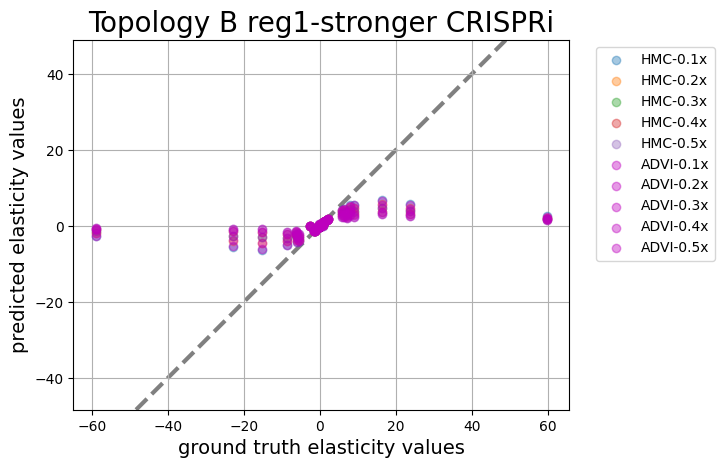

In [43]:
plt.axes().set_aspect('equal', 'datalim')

plt.scatter(hmc_elasticities_df['gt'], hmc_elasticities_df['0.1x'], alpha=0.4, label='HMC-0.1x', zorder=10)
plt.scatter(hmc_elasticities_df['gt'], hmc_elasticities_df['0.2x'], alpha=0.4, label='HMC-0.2x', zorder=10)
plt.scatter(hmc_elasticities_df['gt'], hmc_elasticities_df['0.3x'], alpha=0.4, label='HMC-0.3x', zorder=10)
plt.scatter(hmc_elasticities_df['gt'], hmc_elasticities_df['0.4x'], alpha=0.4, label='HMC-0.4x', zorder=10)
plt.scatter(hmc_elasticities_df['gt'], hmc_elasticities_df['0.5x'], alpha=0.4, label='HMC-0.5x', zorder=10)

plt.scatter(elasticities_df['gt'], elasticities_df['0.1x'], alpha=0.4, label='ADVI-0.1x', zorder=10, c='m')
plt.scatter(elasticities_df['gt'], elasticities_df['0.2x'], alpha=0.4, label='ADVI-0.2x', zorder=10, c='m')
plt.scatter(elasticities_df['gt'], elasticities_df['0.3x'], alpha=0.4, label='ADVI-0.3x', zorder=10, c='m')
plt.scatter(elasticities_df['gt'], elasticities_df['0.4x'], alpha=0.4, label='ADVI-0.4x', zorder=10, c='m')
plt.scatter(elasticities_df['gt'], elasticities_df['0.5x'], alpha=0.4, label='ADVI-0.5x', zorder=10, c='m')


plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values', size=14)
# plt.title('Parity plot of elasticity values for various \nenzyme perturbation strengths—CRISPRi', size=20)
plt.title(f'Topology {topology} {omission} CRISPRi', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


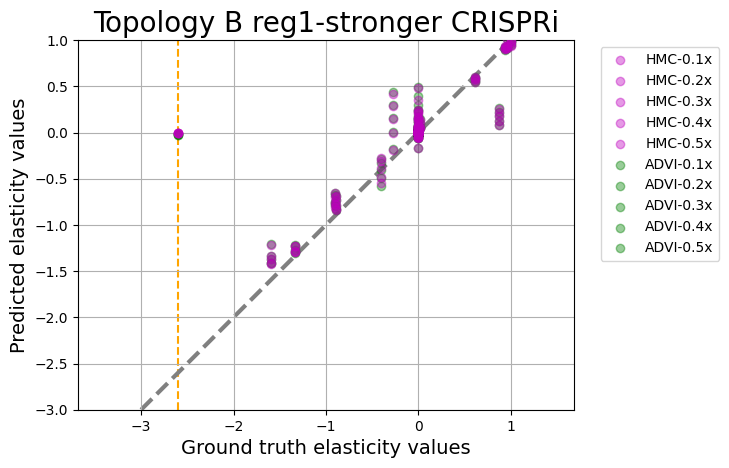

In [44]:
plt.axes().set_aspect('equal', 'datalim')

plt.scatter(hmc_elasticities_df['gt'], hmc_elasticities_df['0.1x'], alpha=0.4, label='HMC-0.1x', zorder=10, c='m')
plt.scatter(hmc_elasticities_df['gt'], hmc_elasticities_df['0.2x'], alpha=0.4, label='HMC-0.2x', zorder=10, c='m')
plt.scatter(hmc_elasticities_df['gt'], hmc_elasticities_df['0.3x'], alpha=0.4, label='HMC-0.3x', zorder=10, c='m')
plt.scatter(hmc_elasticities_df['gt'], hmc_elasticities_df['0.4x'], alpha=0.4, label='HMC-0.4x', zorder=10, c='m')
plt.scatter(hmc_elasticities_df['gt'], hmc_elasticities_df['0.5x'], alpha=0.4, label='HMC-0.5x', zorder=10, c='m')


plt.scatter(elasticities_df['gt'], elasticities_df['0.1x'], alpha=0.4, label='ADVI-0.1x', zorder=5, c='g')
plt.scatter(elasticities_df['gt'], elasticities_df['0.2x'], alpha=0.4, label='ADVI-0.2x', zorder=5, c='g')
plt.scatter(elasticities_df['gt'], elasticities_df['0.3x'], alpha=0.4, label='ADVI-0.3x', zorder=5, c='g')
plt.scatter(elasticities_df['gt'], elasticities_df['0.4x'], alpha=0.4, label='ADVI-0.4x', zorder=5, c='g')
plt.scatter(elasticities_df['gt'], elasticities_df['0.5x'], alpha=0.4, label='ADVI-0.5x', zorder=5, c='g')



plt.axvline(x=elasticities_df.loc['v5_H']['gt'], c='orange', linestyle='dashed', zorder=0)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('Ground truth elasticity values', size=14)
plt.ylabel('Predicted elasticity values', size=14)
# plt.title('Parity plot of elasticity values for various \nenzyme perturbation strengths—CRISPRi', size=20)
plt.title(f'Topology {topology} {omission} CRISPRi', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xlim(-3,1)
plt.ylim(-3,1)
plt.savefig('ci.svg', format='svg')

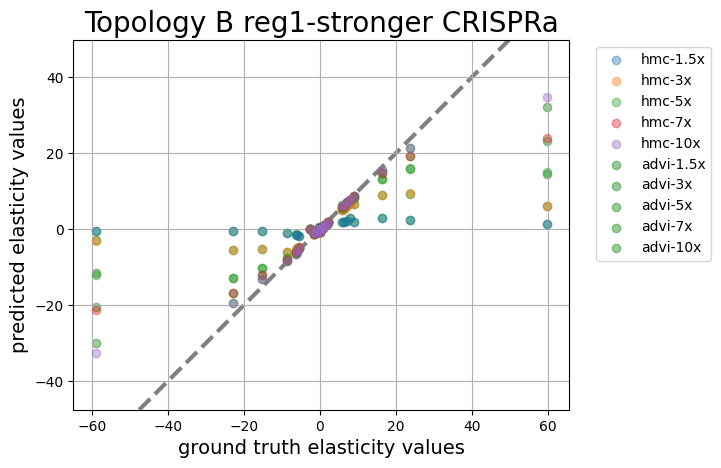

In [20]:
plt.axes().set_aspect('equal', 'datalim')

plt.scatter(hmc_elasticities_df['gt'], hmc_elasticities_df['1.5x'], alpha=0.4, zorder=10, label='hmc-1.5x')
plt.scatter(hmc_elasticities_df['gt'], hmc_elasticities_df['3x'], alpha=0.4, zorder=10, label='hmc-3x')
plt.scatter(hmc_elasticities_df['gt'], hmc_elasticities_df['5x'], alpha=0.4, zorder=10, label='hmc-5x')
plt.scatter(hmc_elasticities_df['gt'], hmc_elasticities_df['7x'], alpha=0.4, zorder=10, label='hmc-7x')
plt.scatter(hmc_elasticities_df['gt'], hmc_elasticities_df['10x'], alpha=0.4, zorder=10, label='hmc-10x')

plt.scatter(elasticities_df['gt'], elasticities_df['1.5x'], alpha=0.4, label='advi-1.5x', c='g')
plt.scatter(elasticities_df['gt'], elasticities_df['3x'], alpha=0.4, label='advi-3x', c='g')
plt.scatter(elasticities_df['gt'], elasticities_df['5x'], alpha=0.4, label='advi-5x', c='g')
plt.scatter(elasticities_df['gt'], elasticities_df['7x'], alpha=0.4, label='advi-7x', c='g')
plt.scatter(elasticities_df['gt'], elasticities_df['10x'], alpha=0.4, label='advi-10x', c='g')

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1,linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values', size=14)
plt.title(f'Topology {topology} {omission} CRISPRa', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


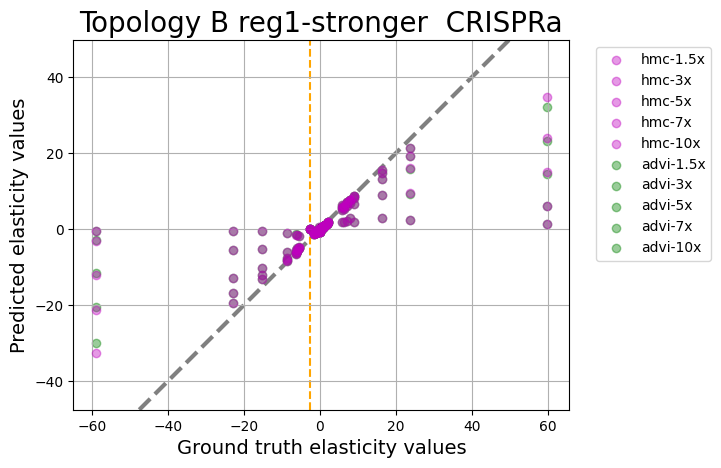

In [ ]:
plt.axes().set_aspect('equal', 'datalim')

plt.scatter(hmc_elasticities_df['gt'], hmc_elasticities_df['1.5x'], alpha=0.4, zorder=10, label='HMC-1.5x', c='m')
plt.scatter(hmc_elasticities_df['gt'], hmc_elasticities_df['3x'], alpha=0.4, zorder=10, label='HMC-3x', c='m')
plt.scatter(hmc_elasticities_df['gt'], hmc_elasticities_df['5x'], alpha=0.4, zorder=10, label='HMC-5x', c='m')
plt.scatter(hmc_elasticities_df['gt'], hmc_elasticities_df['7x'], alpha=0.4, zorder=10, label='HMC-7x', c='m')
plt.scatter(hmc_elasticities_df['gt'], hmc_elasticities_df['10x'], alpha=0.4, zorder=10, label='HMC-10x', c='m')

plt.scatter(elasticities_df['gt'], elasticities_df['1.5x'], alpha=0.4, label='advi-1.5x', c='g')
plt.scatter(elasticities_df['gt'], elasticities_df['3x'], alpha=0.4, label='advi-3x', c='g')
plt.scatter(elasticities_df['gt'], elasticities_df['5x'], alpha=0.4, label='advi-5x', c='g')
plt.scatter(elasticities_df['gt'], elasticities_df['7x'], alpha=0.4, label='advi-7x', c='g')
plt.scatter(elasticities_df['gt'], elasticities_df['10x'], alpha=0.4, label='advi-10x', c='g')

plt.axvline(x=elasticities_df.loc['v5_H']['gt'], c='orange', linestyle='dashed', zorder=0)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1,linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('Ground truth elasticity values', size=14)
plt.ylabel('Predicted elasticity values', size=14)
plt.title(f'Topology {topology} {omission}  CRISPRa', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


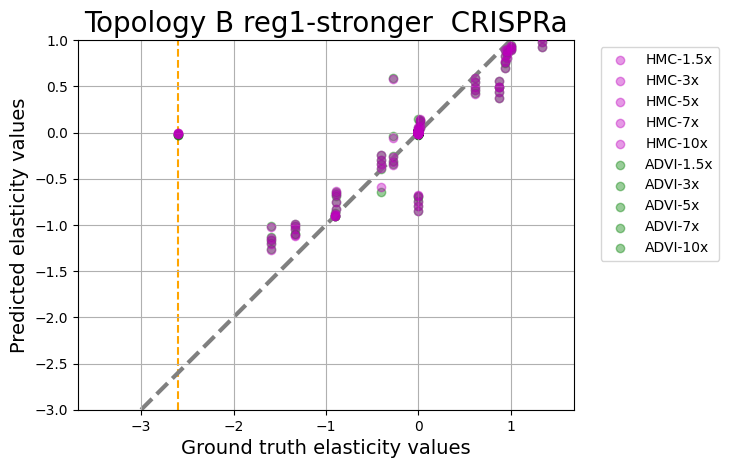

In [45]:
plt.axes().set_aspect('equal', 'datalim')

plt.scatter(hmc_elasticities_df['gt'], hmc_elasticities_df['1.5x'], alpha=0.4, zorder=10, label='HMC-1.5x', c='m')
plt.scatter(hmc_elasticities_df['gt'], hmc_elasticities_df['3x'], alpha=0.4, zorder=10, label='HMC-3x', c='m')
plt.scatter(hmc_elasticities_df['gt'], hmc_elasticities_df['5x'], alpha=0.4, zorder=10, label='HMC-5x', c='m')
plt.scatter(hmc_elasticities_df['gt'], hmc_elasticities_df['7x'], alpha=0.4, zorder=10, label='HMC-7x', c='m')
plt.scatter(hmc_elasticities_df['gt'], hmc_elasticities_df['10x'], alpha=0.4, zorder=10, label='HMC-10x', c='m')

plt.scatter(elasticities_df['gt'], elasticities_df['1.5x'], alpha=0.4, label='ADVI-1.5x', c='g')
plt.scatter(elasticities_df['gt'], elasticities_df['3x'], alpha=0.4, label='ADVI-3x', c='g')
plt.scatter(elasticities_df['gt'], elasticities_df['5x'], alpha=0.4, label='ADVI-5x', c='g')
plt.scatter(elasticities_df['gt'], elasticities_df['7x'], alpha=0.4, label='ADVI-7x', c='g')
plt.scatter(elasticities_df['gt'], elasticities_df['10x'], alpha=0.4, label='ADVI-10x', c='g')

plt.axvline(x=elasticities_df.loc['v5_H']['gt'], c='orange', linestyle='dashed', zorder=0)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1,linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('Ground truth elasticity values', size=14)
plt.ylabel('Predicted elasticity values', size=14)
plt.title(f'Topology {topology} {omission}  CRISPRa', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

plt.xlim(-3,1)
plt.ylim(-3,1)

# expecting value of -2.6 for stronger allosteric regulator
plt.savefig('ca.svg', format='svg')

In [27]:
hmc_elasticities_df['median'] = np.median(hmc_elasticities_df[hmc_elasticities_df.columns[1:]], axis=1)
elasticities_df['median'] = np.median(elasticities_df[elasticities_df.columns[1:]], axis=1)

hmc_elasticities_df['min'] = np.min(hmc_elasticities_df[hmc_elasticities_df.columns[1:]], axis=1)
elasticities_df['min'] = np.min(elasticities_df[elasticities_df.columns[1:]], axis=1)

hmc_elasticities_df['max'] = np.max(hmc_elasticities_df[hmc_elasticities_df.columns[1:]], axis=1)
elasticities_df['max'] = np.max(elasticities_df[elasticities_df.columns[1:]], axis=1)

lower_y_hmc = np.array(hmc_elasticities_df['median']) - hmc_elasticities_df['min'].values
upper_y_hmc =np.array(hmc_elasticities_df['max'].values) - np.array(hmc_elasticities_df['median'])
errors_hmc = [lower_y_hmc, upper_y_hmc]

lower_y_advi = np.array(elasticities_df['median']) - elasticities_df['min'].values
upper_y_advi =np.array(elasticities_df['max'].values) - np.array(elasticities_df['median'])
errors_advi = [lower_y_advi, upper_y_advi]


# np.median()

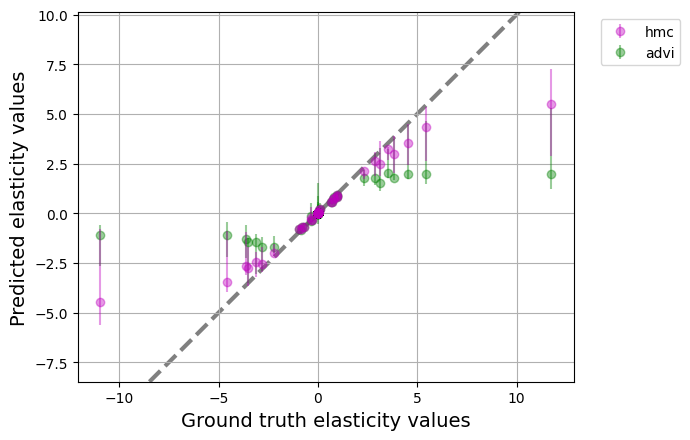

In [ ]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(hmc_elasticities_df['gt'], hmc_elasticities_df['median'], yerr=errors_hmc, fmt='o', alpha=0.4, zorder=10, label='hmc', c='m')
plt.errorbar(elasticities_df['gt'], elasticities_df['median'], yerr=errors_advi, fmt='o', alpha=0.4, label='advi', c='g')

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1,linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('Ground truth elasticity values', size=14)
plt.ylabel('Predicted elasticity values', size=14)
# plt.title('', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

# plt.savefig('../../../visualize/raw_svg_figures/topologyB_elasticities-beetle.svg', format='svg')

## Graphing differences in variance

In [29]:
def make_flat_variances(trace):

    stacked = trace['posterior']['Ex'].stack(sample=("chain", "draw"))
    posterior_variance = stacked.var(dim="sample")
    variances_flat = posterior_variance.values.flatten()

    return variances_flat

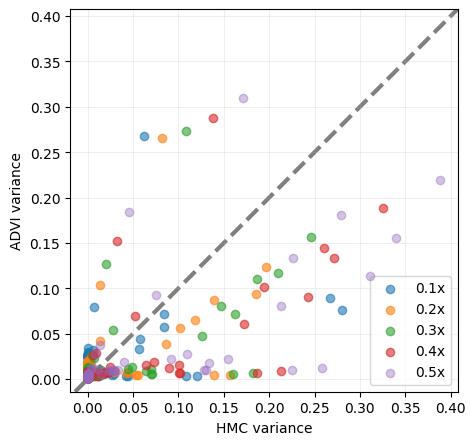

In [30]:
plt.figure(figsize=(5,5))
plt.axes().set_aspect('equal')
plt.grid(zorder=0, alpha=0.2)
plt.scatter(make_flat_variances(hmc_trace01), make_flat_variances(trace01), alpha=0.6, label='0.1x', zorder=100)
plt.scatter(make_flat_variances(hmc_trace02), make_flat_variances(trace02), alpha=0.6, label='0.2x', zorder=100)
plt.scatter(make_flat_variances(hmc_trace03), make_flat_variances(trace03), alpha=0.6, label='0.3x', zorder=100)
plt.scatter(make_flat_variances(hmc_trace04), make_flat_variances(trace04), alpha=0.6, label='0.4x', zorder=100)
plt.scatter(make_flat_variances(hmc_trace05), make_flat_variances(trace05), alpha=0.4, label='0.5x', zorder=100)
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1,linewidth=3)

if xmax > ymax: 
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, xmax)

if ymax > xmax:
    plt.xlim(xmin, ymax)
    plt.ylim(ymin, ymax)

plt.xlabel('HMC variance')
plt.ylabel('ADVI variance')

plt.legend(loc="lower right")
# plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.savefig('../../../visualize/raw_svg_figures/topologyB_crispri_variances-beetle.svg', format='svg')

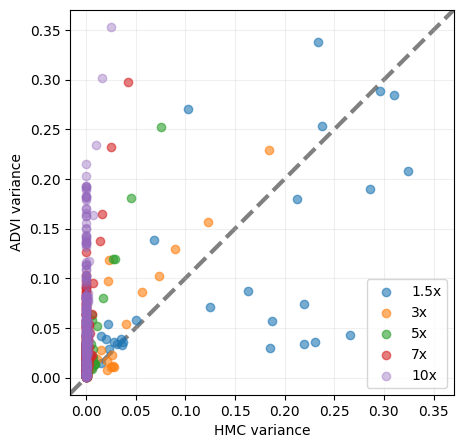

In [31]:
plt.figure(figsize=(5,5))
plt.axes().set_aspect('equal')
plt.grid(zorder=0, alpha=0.2)

plt.scatter(make_flat_variances(hmc_trace15), make_flat_variances(trace15), alpha=0.6, label='1.5x', zorder=100)
plt.scatter(make_flat_variances(hmc_trace3), make_flat_variances(trace3), alpha=0.6, label='3x', zorder=100)
plt.scatter(make_flat_variances(hmc_trace5), make_flat_variances(trace5), alpha=0.6, label='5x', zorder=100)
plt.scatter(make_flat_variances(hmc_trace7), make_flat_variances(trace7), alpha=0.6, label='7x', zorder=100)
plt.scatter(make_flat_variances(hmc_trace100), make_flat_variances(trace100), alpha=0.4, label='10x', zorder=100)

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1,linewidth=3)
if xmax > ymax: 
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, xmax)

if ymax > xmax:
    plt.xlim(xmin, ymax)
    plt.ylim(ymin, ymax)
plt.xlabel('HMC variance')
plt.ylabel('ADVI variance')

plt.legend(loc="lower right")
# plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

plt.savefig('../../../visualize/raw_svg_figures/topologyB_crispra_variances-beetle.svg', format='svg')